<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/GluonTS_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
#install GluonTS
#!pip install --upgrade mxnet~=1.7 gluonts

In [3]:
#metatrader 5 history file an timeframe is ok
df = pd.read_csv('/content/EURUSD_H1_200001120000_202201120100.csv')


In [4]:
#split mt5 into columns
df.columns=['header']
df = df.header.str.split('\t', expand=True)

In [5]:
#check the splits
df

,0,1,2,3,4,5,6,7,8
0,2000.01.12,00:00:00,1.03370,1.03380,1.03300,1.03360,132,0,50
1,2000.01.12,01:00:00,1.03370,1.03380,1.03190,1.03220,221,0,50
2,2000.01.12,02:00:00,1.03260,1.03300,1.03190,1.03290,171,0,50
3,2000.01.12,03:00:00,1.03280,1.03350,1.03230,1.03280,195,0,50
4,2000.01.12,04:00:00,1.03290,1.03380,1.03280,1.03330,145,0,50
...,...,...,...,...,...,...,...,...,...
136563,2022.01.11,21:00:00,1.13667,1.13753,1.13627,1.13667,1775,0,0
136564,2022.01.11,22:00:00,1.13668,1.13694,1.13638,1.13657,1757,0,0
136565,2022.01.11,23:00:00,1.13657,1.13693,1.13648,1.13666,772,0,0
136566,2022.01.12,00:00:00,1.13655,1.13681,1.13624,1.13681,628,0,16


In [6]:
#merge date and time to convert object to datetime to use as GluonTS index
selected_columns = df[[0,1,5]]
new_df = selected_columns.copy()
print(new_df)

                 0         1        5
0       2000.01.12  00:00:00  1.03360
1       2000.01.12  01:00:00  1.03220
2       2000.01.12  02:00:00  1.03290
3       2000.01.12  03:00:00  1.03280
4       2000.01.12  04:00:00  1.03330
...            ...       ...      ...
136563  2022.01.11  21:00:00  1.13667
136564  2022.01.11  22:00:00  1.13657
136565  2022.01.11  23:00:00  1.13666
136566  2022.01.12  00:00:00  1.13681
136567  2022.01.12  01:00:00  1.13656

[136568 rows x 3 columns]


In [7]:
new_df['date_time_index'] = df[0] +' '+ df[1]
new_df = new_df.drop(columns = [0,1])

In [8]:
new_df = new_df.rename(columns={5:'price'})

In [9]:
#convert mt5 object formats to datetime and float
df2 = new_df[['date_time_index','price']]
df2['date_time_index'] = pd.to_datetime(df2['date_time_index'])
df2['price'] = df2['price'].astype(float, errors = 'raise')
df2 = df2.set_index('date_time_index')
print(df2)

                       price
date_time_index             
2000-01-12 00:00:00  1.03360
2000-01-12 01:00:00  1.03220
2000-01-12 02:00:00  1.03290
2000-01-12 03:00:00  1.03280
2000-01-12 04:00:00  1.03330
...                      ...
2022-01-11 21:00:00  1.13667
2022-01-11 22:00:00  1.13657
2022-01-11 23:00:00  1.13666
2022-01-12 00:00:00  1.13681
2022-01-12 01:00:00  1.13656

[136568 rows x 1 columns]


In [10]:
#check it is done
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136568 entries, 2000-01-12 00:00:00 to 2022-01-12 01:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   price   136568 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


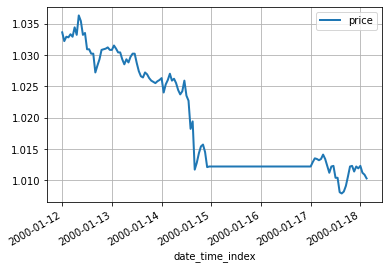

In [11]:
#print the data range from above
import matplotlib.pyplot as plt
df2[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [12]:
#import Gluon
from gluonts.dataset.common import ListDataset

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [13]:
#choose data range to train
training_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price["2000-01-01 00:00:00":"2022-01-12 00:00:00"]}], 
    freq = "1H"
    )

In [14]:
#import model 
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

In [ ]:
#train model
estimator = DeepAREstimator(freq="1H", prediction_length=24, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=training_data)

 78%|███████▊  | 39/50 [00:10<00:02,  3.82it/s, epoch=1/10, avg_epoch_loss=0.119]

In [ ]:
#choose data range to predict
test_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price[:"2022-01-12 00:00:00"]}],
    freq = "1H"
)

In [ ]:
#plot prediction graph
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-60:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[1.0, 5.0])
plt.grid(which='both')